In [1]:
import napari
import napari_workflows as nw
from skimage.io import imread
file_name = r'C:/Users/ryans/Desktop/blobs.tif'
blobs = imread(file_name)

In [2]:
from napari_workflows._io_yaml_v1 import load_workflow, save_workflow        
filename = 'workflow from napari.yaml'

loaded_wf = load_workflow(filename)
print(loaded_wf)

Workflow:
Result of Connected component labeling (scikit-image, nsbatwm) <- (<function connected_component_labeling at 0x00000265EF60DBD0>, 'Result of Expand labels (scikit-image, nsbatwm)', False)
Result of Expand labels (scikit-image, nsbatwm) <- (<function expand_labels at 0x00000265EF60DEA0>, 'Result of Threshold (Li et al 1993, scikit-image, nsbatwm)', 4.0)
Result of Gaussian (scikit-image, nsbatwm) <- (<function gaussian_blur at 0x00000265EF60CF70>, 'blobs', 4.0)
Result of Percentile (scipy, nsbatwm) <- (<function percentile_filter at 0x00000265EF60D2D0>, 'Result of Gaussian (scikit-image, nsbatwm)', 2.0, 4.0)
Result of Threshold (Li et al 1993, scikit-image, nsbatwm) <- (<function threshold_li at 0x00000265EF60CA60>, 'Result of Percentile (scipy, nsbatwm)')



In [3]:
import inspect
import magicgui
from functools import partial
from napari_tools_menu import make_gui
from inspect import Signature, signature
from functools import partial


def signature_w_kwargs_from_function(function, arg_vals: list) -> Signature:
    
    # getting the keywords corresponding to the values
    keyword_list = list(signature(function).parameters.keys())

    # creating the kwargs dict
    kw_dict = {}
    for kw, val in zip(keyword_list, arg_vals):
        kw_dict[kw] = val
        
    possible_input_image_names = ['image',
                                  'label_image',
                                  'binary_image'
                                 ]
    for name in possible_input_image_names:
        try:
            kw_dict.pop(name) # we are making an assumption that the input will aways be this
        except KeyError:
            pass

    
    sig = signature(partial(function, **kw_dict))
    
    return sig


In [4]:
roots = loaded_wf.roots()
roots

['blobs']

In [5]:
loaded_wf._tasks.items()

dict_items([('Result of Connected component labeling (scikit-image, nsbatwm)', (<function connected_component_labeling at 0x00000265EF60DBD0>, 'Result of Expand labels (scikit-image, nsbatwm)', False)), ('Result of Expand labels (scikit-image, nsbatwm)', (<function expand_labels at 0x00000265EF60DEA0>, 'Result of Threshold (Li et al 1993, scikit-image, nsbatwm)', 4.0)), ('Result of Gaussian (scikit-image, nsbatwm)', (<function gaussian_blur at 0x00000265EF60CF70>, 'blobs', 4.0)), ('Result of Percentile (scipy, nsbatwm)', (<function percentile_filter at 0x00000265EF60D2D0>, 'Result of Gaussian (scikit-image, nsbatwm)', 2.0, 4.0)), ('Result of Threshold (Li et al 1993, scikit-image, nsbatwm)', (<function threshold_li at 0x00000265EF60CA60>, 'Result of Percentile (scipy, nsbatwm)'))])

In [6]:
def wf_steps_with_root_as_input(workflow):
    roots = loaded_wf.roots()
    wf_step_with_rootinput = []
    for result, task in workflow._tasks.items():
            for source in task:
                if isinstance(source, str):
                    if source in roots:
                        wf_step_with_rootinput.append(result)
    return wf_step_with_rootinput

root_functions = wf_steps_with_root_as_input(loaded_wf)     
root_functions

['Result of Gaussian (scikit-image, nsbatwm)']

In [7]:
from napari_workflows import Workflow
workflow = loaded_wf

def old_wf_names_to_new_mapping(workflow: Workflow)-> dict:
    mapping = {}
    for old_key, content in workflow._tasks.items():
        func = content[0]
        new_name = 'Result of ' + func.__name__
        mapping[old_key] = new_name
    
    return mapping

old_to_new_name_mapping = old_wf_names_to_new_mapping(workflow)
old_to_new_name_mapping

{'Result of Connected component labeling (scikit-image, nsbatwm)': 'Result of connected_component_labeling',
 'Result of Expand labels (scikit-image, nsbatwm)': 'Result of expand_labels',
 'Result of Gaussian (scikit-image, nsbatwm)': 'Result of gaussian_blur',
 'Result of Percentile (scipy, nsbatwm)': 'Result of percentile_filter',
 'Result of Threshold (Li et al 1993, scikit-image, nsbatwm)': 'Result of threshold_li'}

C:\Users\ryans\anaconda3\envs\np_workflows_v1\lib\site-packages\napari_tools_menu\__init__.py:165: FutureWarning: Public access to Window.qt_viewer is deprecated and will be removed in
v0.5.0. It is considered an "implementation detail" of the napari
application, not part of the napari viewer model. If your use case
requires access to qt_viewer, please open an issue to discuss.
  self.tools_menu = ToolsMenu(self, self.qt_viewer.viewer)


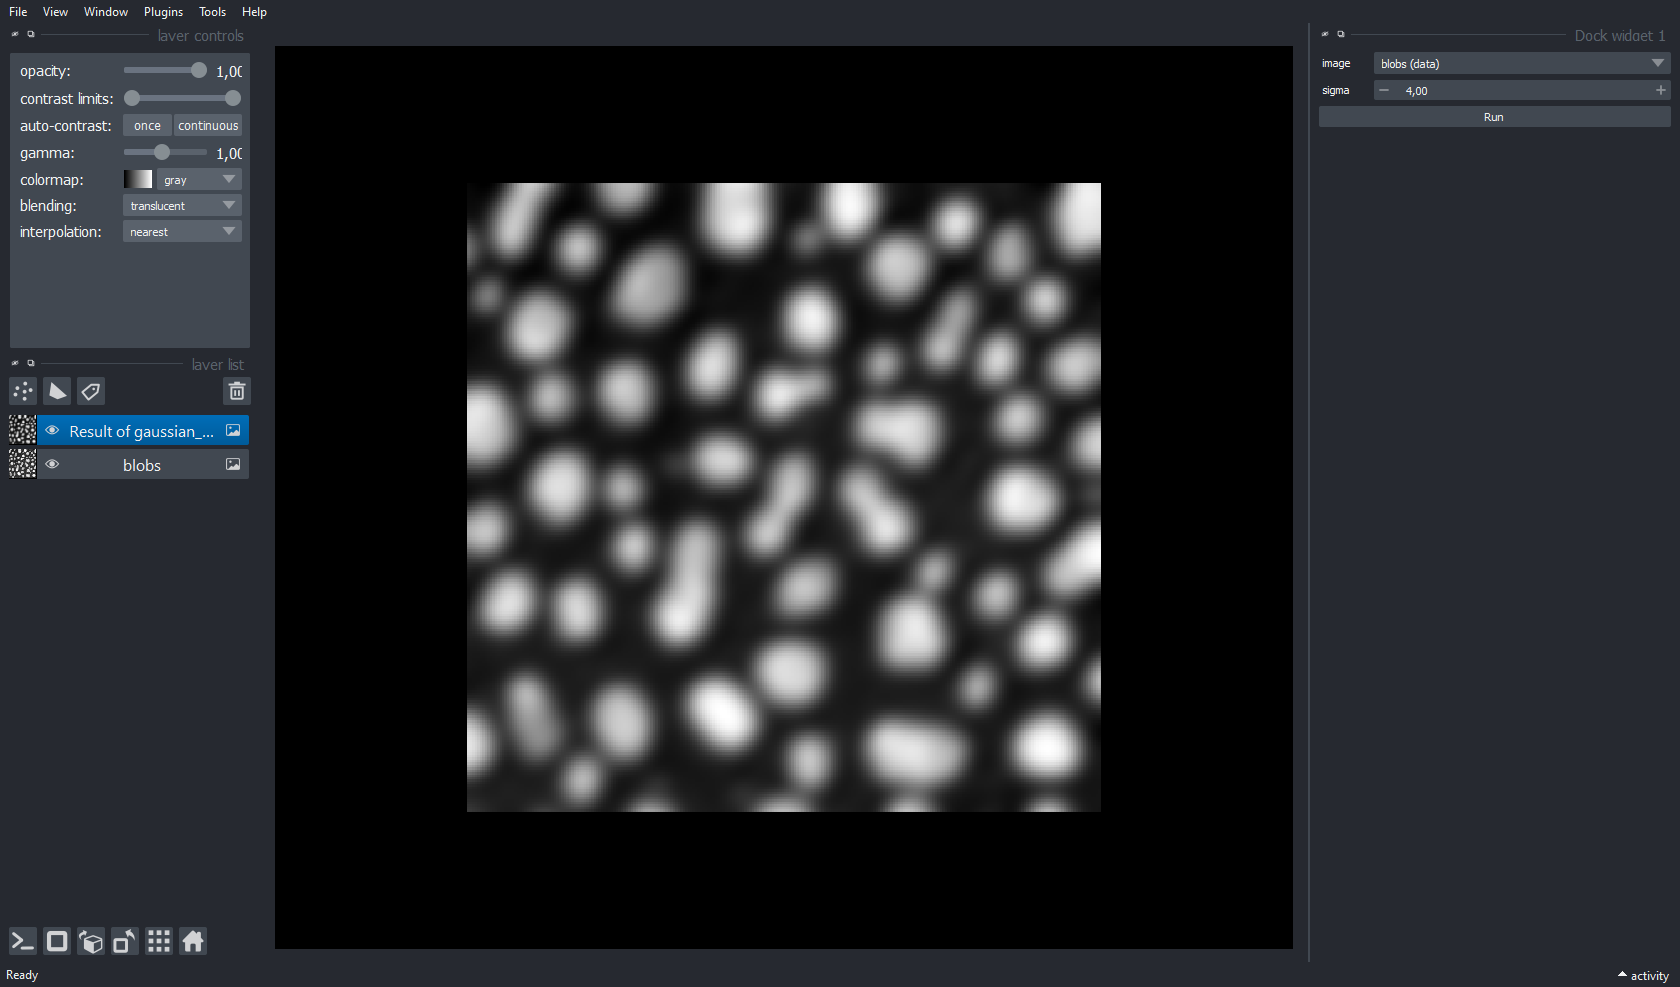

In [8]:
viewer3 = napari.Viewer()
viewer3.add_image(blobs)

layers = viewer3.layers
for i, wf_step_name in enumerate(root_functions):
    func = workflow._tasks[wf_step_name][0]
    args = workflow._tasks[wf_step_name][1:] 
    
    signat = signature_w_kwargs_from_function(func, args)
    func.__signature__ = signat
    widget = make_gui(func, viewer3)
    
    
    viewer3.window.add_dock_widget(widget)
    widget(layers[i].data)

napari.utils.nbscreenshot(viewer3)

In [9]:
def direct_follower_of_node(workflow, workflow_step):
    for step, task in workflow._tasks.items():
            for source in task:
                if isinstance(source, str):
                    if source == workflow_step:
                        return step

print(direct_follower_of_node(workflow,root_functions[0]))                    

Result of Percentile (scipy, nsbatwm)


In [10]:
from magicgui.widgets import FunctionGui

class flexible_gui(FunctionGui):
    def __init__(self, function,param_options):
        super().__init__(
          function,
          call_button=True,
          layout='vertical',
          #auto_call=True,
          param_options=param_options
        )
        
def get_parameter_options(workflow, wf_step, viewer, old_wf_names_to_new_mapping = None):
    

    func = workflow._tasks[wf_step][0]
    args = workflow._tasks[wf_step][1:]

    keyword_list = list(signature(func).parameters.keys())
    image_keywords = [(key,value) for key, value in zip(keyword_list,args) if isinstance(value, str)]
    image_names = [key for key, value in zip(keyword_list,args) if isinstance(value, str)]

    if old_wf_names_to_new_mapping is None:
        conversion_dict = {name: name for name in image_names}
    else:
        conversion_dict = old_wf_names_to_new_mapping

    param_options = {}
    for key, name in image_keywords:
        param_options[key] = {'choices': [viewer.layers[conversion_dict[name]]]}

    return param_options

In [11]:
appendable_roots = root_functions

new_mapping = {}
for old_key, content in workflow._tasks.items():
    func = content[0]
    new_name = func.__name__+ ' result'
    new_mapping[old_key] = new_name
    

for root in appendable_roots:
    followers = [direct_follower_of_node(workflow,root)]
    
    for follower in followers:
        
        # insert check if all the requirements are made
        # if not skip this step and append current node to the node list
        
        sources = workflow.sources_of(follower)
        if len(sources) == 1: # this means only functions with imge -> image work (for now)
            source = sources[0]
            
            
            func = workflow._tasks[follower][0]
            args = workflow._tasks[follower][1:]
            
            signat = signature_w_kwargs_from_function(func, args)
            
            try:
                params = get_parameter_options(workflow, 
                                           wf_step= follower, 
                                           viewer= viewer3, 
                                           old_wf_names_to_new_mapping= old_to_new_name_mapping)
            except KeyError:
                params = get_parameter_options(workflow, 
                                               wf_step= follower, 
                                               viewer= viewer3, 
                                               old_wf_names_to_new_mapping= new_mapping)
            
            func.__signature__ = signat
            
            
            widget = flexible_gui(func,params)
            viewer3.window.add_dock_widget(widget, name = func.__name__)
            
            try:
                widget(layers[old_to_new_name_mapping[source]].data)
            except KeyError:
                widget(layers[new_mapping[source]].data)
            
            new_direct_follower = direct_follower_of_node(workflow,follower)
            followers.append(new_direct_follower)

In [12]:
from napari import Viewer
wf_manager = nw.WorkflowManager.install(viewer3)
manager_wf = wf_manager.workflow

def print_clean_workflow(workflow):
    print('Workflow:')
    for step, parameters in workflow._tasks.items():
        print_params = tuple([param for param in parameters if not isinstance(param,Viewer)])
        print(step + ' <- ' + str(print_params))
            
print_clean_workflow(manager_wf)

Workflow:
Result of gaussian_blur <- (<function gaussian_blur at 0x00000265EF60CF70>, 'blobs', 4.0)


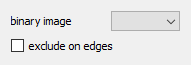

In [13]:
import magicgui
widget = magicgui.magicgui(func, auto_call= True)
widget